# Simulación Estocástica
## Método de Aceptación–Rechazo

Notebook unificado con teoría y práctica. Objetivo: ilustrar cómo simular variables aleatorias complejas a partir de distribuciones sencillas usando aceptación–rechazo.


## 1. Idea general

Sea la densidad objetivo $f(x)$ y una propuesta simulable $g(x)$. Buscamos $c$ tal que
$\frac{f(x)}{g(x)} \le c \quad \forall x.$

**Algoritmo (continuo):**
1. Generar $Y \sim g$.
2. Generar $U \sim \mathrm{Unif}(0,1)$.
3. Aceptar $X=Y$ si $U \le \frac{f(Y)}{c\,g(Y)}$. Si no, repetir.

**Propiedades:**
- $X \sim f$.
- Número de iteraciones $\sim \mathrm{Geom}(1/c)$ con media $c$.


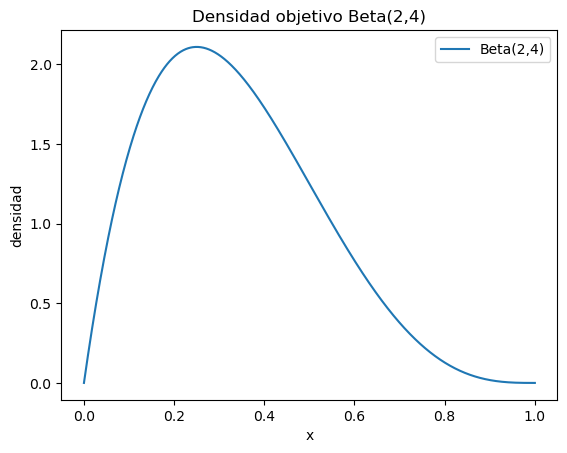

In [1]:
# Ejemplo: Beta(2,4) como objetivo y Uniforme(0,1) como propuesta
import numpy as np
import matplotlib.pyplot as plt

def f_beta24(x):
    return 20.0 * x * (1.0 - x)**3

x_values = np.linspace(0, 1, 1000)
plt.figure()
plt.plot(x_values, f_beta24(x_values), label="Beta(2,4)")
plt.xlabel("x")
plt.ylabel("densidad")
plt.title("Densidad objetivo Beta(2,4)")
plt.legend()
plt.show()


## 2. Caso Beta(2,4)

Densidad objetivo en $(0,1)$:
$
f(x) = 20\,x(1-x)^3.
$

Propuesta: $g(x)=\mathrm{Unif}(0,1)$.

Constante óptima (máximo de $f$): $c = f(1/4) = 135/64$.

Probabilidad de aceptación: $1/c = 64/135 \approx 0.474$.


Media empirica de iteraciones: 2.08115   c teorico: 2.109375


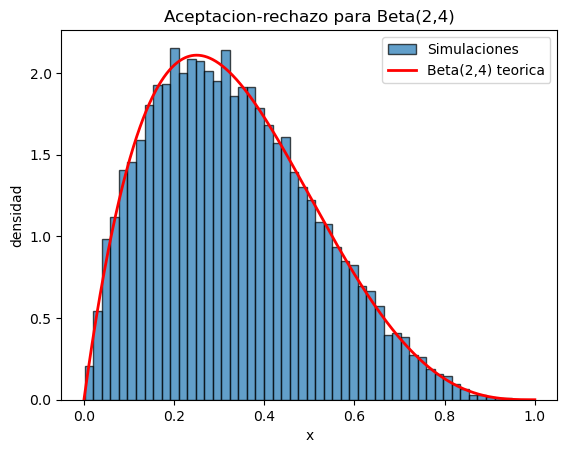

In [2]:
c_beta = 135.0/64.0

def rbeta24_ar(k, rng=None):
    """Simula k observaciones de Beta(2,4) por aceptacion-rechazo con propuesta U(0,1)."""
    if rng is None:
        rng = np.random.default_rng()
    sim = []
    iters = []
    for _ in range(k):
        cnt = 1
        y = rng.random()
        u = rng.random()
        while u > f_beta24(y)/c_beta:
            y = rng.random()
            u = rng.random()
            cnt += 1
        sim.append(y)
        iters.append(cnt)
    return np.array(sim), np.array(iters)

x, contador = rbeta24_ar(20000)
print("Media empirica de iteraciones:", contador.mean(), "  c teorico:", c_beta)

plt.figure()
plt.hist(x, bins=50, density=True, edgecolor="black", alpha=0.7, label="Simulaciones")
plt.plot(x_values, f_beta24(x_values), "r-", lw=2, label="Beta(2,4) teorica")
plt.title("Aceptacion-rechazo para Beta(2,4)")
plt.xlabel("x")
plt.ylabel("densidad")
plt.legend()
plt.show()


**Observaciones:**
- El histograma se ajusta a la curva teórica.
- La media de iteraciones aproxima $c \approx 2.109375$.


## 3. Normal estándar por aceptación–rechazo

Construcción en dos fases:
1. Simular $|Z|$ con propuesta exponencial y aceptación–rechazo.
2. Asignar signo $\pm 1$ con probabilidad $1/2$ para obtener $Z\sim\mathcal N(0,1)$.

Este esquema ilustra aceptación–rechazo; no es el más eficiente posible, pero es didáctico.


E[iteraciones] empirica: 1.31045


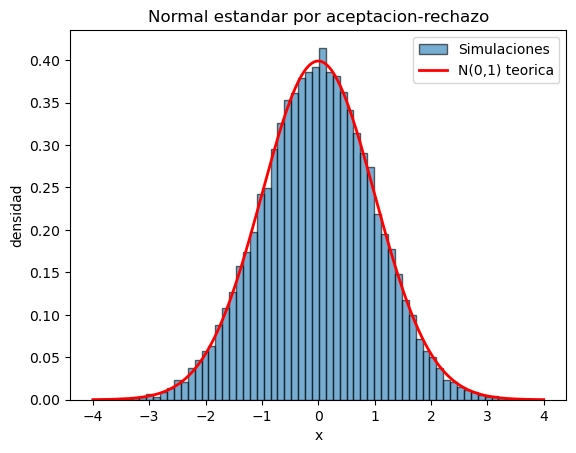

In [3]:
import math

def rabsnorm_ar(k, rng=None):
    """Simula k observaciones de |Z| por aceptacion-rechazo a partir de Exp(1)."""
    if rng is None:
        rng = np.random.default_rng()
    sims = []
    iters = []
    for _ in range(k):
        cnt = 1
        u1 = rng.random()
        y = -np.log(u1)  # propuesta Exp(1)
        u2 = rng.random()
        # criterio tomado del notebook de clase: aceptar si u2 <= exp(-0.5*(y-1)^2)
        while u2 > np.exp(-0.5 * (y - 1.0)**2):
            u1 = rng.random()
            y = -np.log(u1)
            u2 = rng.random()
            cnt += 1
        sims.append(y)
        iters.append(cnt)
    return np.array(sims), np.array(iters)

def rnorm_stand_ar(k, rng=None):
    """Simula k observaciones de N(0,1) a partir de |Z| y signo +/-1."""
    if rng is None:
        rng = np.random.default_rng()
    absZ, iters = rabsnorm_ar(k, rng)
    signs = np.where(rng.random(k) < 0.5, 1.0, -1.0)
    return absZ * signs, iters

z, itz = rnorm_stand_ar(20000)
print("E[iteraciones] empirica:", itz.mean())

plt.figure()
plt.hist(z, bins=60, density=True, edgecolor="black", alpha=0.6, label="Simulaciones")
x = np.linspace(-4, 4, 500)
phi = (1/np.sqrt(2*math.pi))*np.exp(-x**2/2)
plt.plot(x, phi, "r-", lw=2, label="N(0,1) teorica")
plt.title("Normal estandar por aceptacion-rechazo")
plt.xlabel("x")
plt.ylabel("densidad")
plt.legend()
plt.show()


**Notas:**
- Simetría garantizada por el paso de signo.
- Valores típicos de $\mathbb E[\text{iteraciones}]$ rondan 1.31 con este criterio.


## 4. Caso general Gamma $\mathrm{Gamma}(\alpha,\lambda)$

Densidad objetivo:
$
f(x) = \frac{\lambda^\alpha}{\Gamma(\alpha)}\,x^{\alpha-1} e^{-\lambda x}, \quad x>0.
$

Propuesta exponencial $g(x)=\mu e^{-\mu x}$. El factor
$
\frac{f(x)}{g(x)} = \frac{\lambda^\alpha}{\Gamma(\alpha)\,\mu} \, x^{\alpha-1} e^{(\mu-\lambda)x}.
$

Para $\alpha>1$, el óptimo que minimiza $c$ es $\mu^\star = \lambda/\alpha$.
La propuesta comparte la media con la gamma: $\mathbb E[X]=\alpha/\lambda$ y $\mathbb E_g[Y]=1/\mu^\star=\alpha/\lambda$.


Media de iteraciones empirica: 1.2587   c estimado: 1.2573167664342257


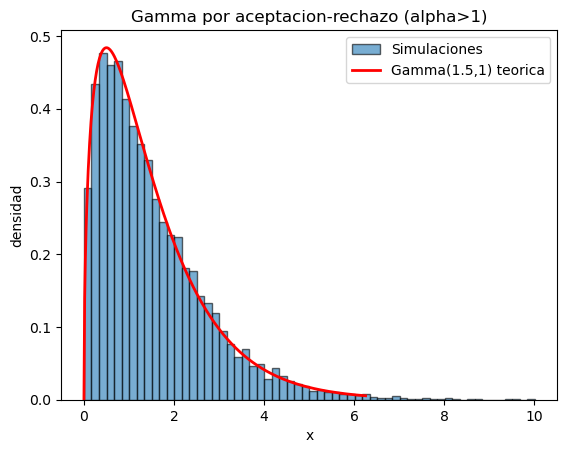

In [4]:
# Generador Gamma(alpha, lambda) (educativo) por aceptacion-rechazo con propuesta Exp(mu=lambda/alpha), alpha>1
from math import gamma

def rgamma_ar(k, alpha, lam, rng=None):
    if alpha <= 1:
        raise ValueError("Esta version exige alpha > 1 para estabilidad del mayorazgo.")
    if rng is None:
        rng = np.random.default_rng()
    mu = lam/alpha
    K = (lam**alpha)/gamma(alpha)
    # punto critico del maximo de f/g
    x_star = (alpha - 1.0) / (lam - mu)
    c = (K/mu) * (x_star**(alpha-1.0)) * np.exp((mu - lam)*x_star)
    sims, iters = [], []
    for _ in range(k):
        cnt = 1
        y = rng.exponential(1.0/mu)
        u = rng.random()
        while u > (K*np.exp(-lam*y)*y**(alpha-1.0)) / (c * (mu*np.exp(-mu*y))):
            y = rng.exponential(1.0/mu)
            u = rng.random()
            cnt += 1
        sims.append(y)
        iters.append(cnt)
    return np.array(sims), np.array(iters), c

xg, itg, c_est = rgamma_ar(10000, alpha=1.5, lam=1.0)
print("Media de iteraciones empirica:", itg.mean(), "  c estimado:", c_est)

plt.figure()
plt.hist(xg, bins=60, density=True, edgecolor="black", alpha=0.6, label="Simulaciones")
xx = np.linspace(0, np.quantile(xg, 0.995), 400)
fg = (1/ math.gamma(1.5)) * (xx**(1.5-1)) * np.exp(-xx)  # lam=1
plt.plot(xx, fg, "r-", lw=2, label="Gamma(1.5,1) teorica")
plt.title("Gamma por aceptacion-rechazo (alpha>1)")
plt.xlabel("x")
plt.ylabel("densidad")
plt.legend()
plt.show()


## 5. Conclusiones

- Aceptación–rechazo es general, simple y modular.
- Eficiencia controlada por $c$. Si $c$ es grande, el método se degrada.
- Casos didácticos: Beta(2,4), Normal estándar, Gamma($\alpha>1$).
- Para producción, considere alternativas más eficientes cuando existan (inversa, Box–Muller, ziggurat, Cheng–Feast, Marsaglia–Tsang).
